# Итоговая расчетная работа

Порядок действий:

1. Перейдем от передаточной функции к ДУ; Решим ДУ явным методом Эйлера
относительно y и получим массив данных y(t);
2. Реализуем ГСЧ для чисел, распределенных по нормальному закону.
3. Сформируем шум; Получим «зашумленные» значения выходного сигнала и их
график – добавим шумы к значениям выходного сигнала в каждой точке таблицы.
4. Сформируем целевую функцию;
5. Реализуем метод оптимизации, проверим его на тестовой функции;
6. Выполним параметрическую идентификацию полученным методом оптимизации
по зашумленному массиву данных.

## Подготовка


In [1]:
import math

import pandas as pd
import numpy as np
from numpy.random import uniform as random
from scipy import stats

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from matplotlib.lines import Line2D
from IPython.display import HTML

from matplotlib.widgets import CheckButtons
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

import seaborn as sns

from typing import Generator, List
%matplotlib widget

matplotlib.rcParams['font.size'] = 14

## 1 этап. Получения массива данных от передаточной функции

Исходная передаточная функция: $ W(s) = \frac{k(1+a_1*s)}{1+2 * \mu*T*s+T^2*s^2} = \frac{\bar{y}(s)}{\bar{x}(s)} = \frac{P(s)}{Q(s)} $

где: $ x(t) = const = 12, k = 2, a_1 = 2, \mu = 0.3, T = 2 $

In [2]:
def transfer_func(xt:float, k:float, a1:float, mu:float, T:float, h: float) -> Generator[float, float, None]:
    """
    Реализация решения передаточной функции через метод Эйлера.
    (генераторная функция)
    
    xt, k, a1, mu, T: float - параметры передаточной функции
    h: float - шаг
    return: значение функции
    """
    z1, z2 = 0, 0
    while True:
        yield (k * z1 + k * a1 * z2)
        z1 = z1 + h * z2
        z2 = z2 + h * -((z1 + 2 * mu * T * z2 - xt) / (T*T))

In [3]:
# получение массива данных из передаточной функции. (250 точек)
h: float = 0.15
f: Generator[float, float, None] = transfer_func(12, 2, 2, 0.3, 2, h)
    
clean_result = []
for _ in range(250):
    clean_result.append(next(f))

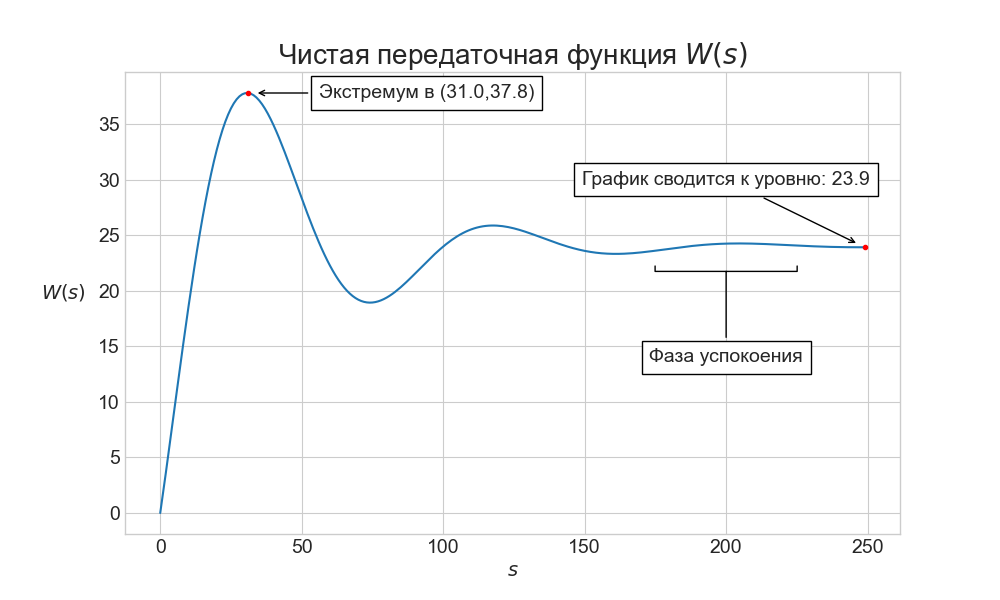

In [4]:
# Визуализация 
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(clean_result)

ax.set_xlabel('$s$', fontsize=14)
ax.set_ylabel('$W(s)$', fontsize=14, rotation=0, labelpad=25)
ax.set_title('Чистая передаточная функция $W(s)$', fontsize=20)

# Аннотации
max_dot = (clean_result.index(max(clean_result)), max(clean_result))
ax.plot(max_dot[0], max_dot[1], ".r")
offsetbox = TextArea(f"Экстремум в ({max_dot[0]:2.1f},{max_dot[1]:2.1f})")
annotate_max = AnnotationBbox(offsetbox, max_dot,
                    xybox=(0.25,max_dot[1]),
                    xycoords='data',
                    boxcoords=("axes fraction", "data"),
                    box_alignment=(0., 0.5),
                    arrowprops=dict(arrowstyle='->, head_length=0.2, head_width=0.1', shrinkB=7))
ax.add_artist(annotate_max)

offsetbox = TextArea(f"Фаза успокоения")
phase = AnnotationBbox(offsetbox, (200, clean_result[200]),
                    xybox=(200, 14),
                    xycoords='data',
                    boxcoords=('data'),
                    box_alignment=(0.5, 0.5),
                    arrowprops=dict(
                        arrowstyle='-[, widthB=2.63',
                        shrinkB=20)
                      )
ax.add_artist(phase)

normal_dot = (249, clean_result[-1])
ax.plot(normal_dot[0], normal_dot[1], ".r")
offsetbox = TextArea(f"График сводится к уровню: {normal_dot[1]:2.1f}")
annotate_normal = AnnotationBbox(offsetbox, normal_dot,
                    xybox=(200, 30),
                    xycoords='data',
                    boxcoords=("data", "data"),
                    box_alignment=(0.5, 0.5),
                    arrowprops=dict(arrowstyle='->, head_length=0.2, head_width=0.1', shrinkB=7))
ax.add_artist(annotate_normal)


plt.show()

## 2 Этап. Формирования ГСЧ методом Мюллера

**Закон распределения**:
* $ Z_1 = \cos{(2\pi * r_1)} * \sqrt{-2 * ln(r_2)}$

или

* $ Z_2 = \sin{(2\pi * r_1)} * \sqrt{-2 * ln(r_2)}$

Статистики таких чисел будут равны: $ m_V = 0 $ и $ \sigma_V = 1 $

**Масштабирование**: 

$ x = z * \sigma_x + m_x $, где

$ \sigma_x = \Delta y = 0.05 * MAX_{табличный} |y(t)| $

In [5]:
def generate_muller(size:int, dy:float) -> List[float]: 
    """
    Генератор чисел по закону Нормального распределения
    
    size: int - размер выборки
    dy: float - параметр масштабирования
    return: List[float] - Массив, сгенерированный по закону Нормального распределения
    """
    arr = []
    sx = 0.05 * 37.93984 # из РГР-1
    for _ in range(size // 2):
        r1, r2 = random(size=2)
        z1: float = np.cos(2 * np.pi * r1) * np.sqrt(-2 * math.log(r2))
        z2: float = np.sin(2 * np.pi * r1) * np.sqrt(-2 * math.log(r2))
        arr.extend([z1 * sx, z2 * sx])
    return arr

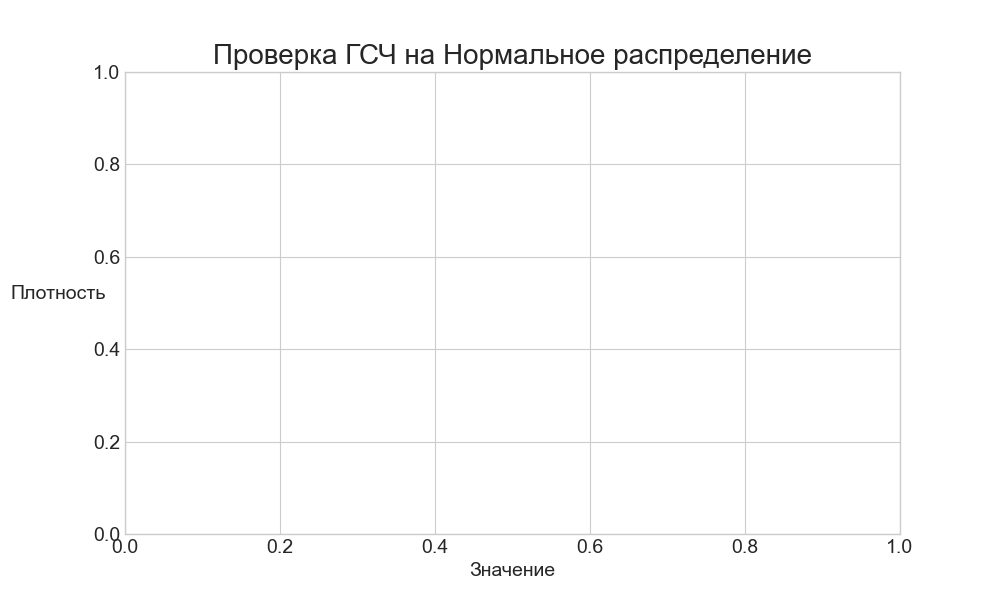

In [6]:
# проверка на нормальное распределение и визуализация
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Значение', fontsize=14)
ax.set_ylabel('Плотность', fontsize=14, rotation=0, labelpad=25)
ax.set_title('Проверка ГСЧ на Нормальное распределение', fontsize=20)

def update_plot(size):
    global ax,s
    size *= 75
    new_data = generate_muller(size, dy=max(clean_result))
    
    
    ax.clear()
    ax.set_xlim(-8, 8)
    ax.set_ylim(0, 0.4)
    ax = sns.histplot(
        new_data,
        bins=25,
        stat="density",
    )
    ax = sns.kdeplot(
        new_data,
        color='r',
        legend=True,
        linewidth=3,
    )
    ax.set_xlabel('Значение', fontsize=14)
    ax.set_ylabel('Плотность', fontsize=14, rotation=90, labelpad=25)
    ax.set_title('Проверка ГСЧ на Нормальное распределение', fontsize=20)
    
    offsetbox = TextArea(f"Размер выборки: {size}")
    phase = AnnotationBbox(offsetbox, (6, 0.3),
                        xybox=(6, 0.3),
                        xycoords='data',
                        boxcoords=('data'),
                        box_alignment=(0.5, 0.5))
    ax.add_artist(phase)
    
anim = animation.FuncAnimation(fig, update_plot, frames=35, interval=50, blit=True, repeat=False)
plt.show()

## Этап 3. Формирования шума. "Зашумление" выходного сигнала придаточной функции. График "зашумленной" функции

In [7]:
# Формирование шума
dy = max(clean_result)
noise = generate_muller(len(clean_result), dy=dy)

In [8]:
# Зашумление
noise_result = [n1+n2 for (n1, n2) in zip(clean_result, noise)]

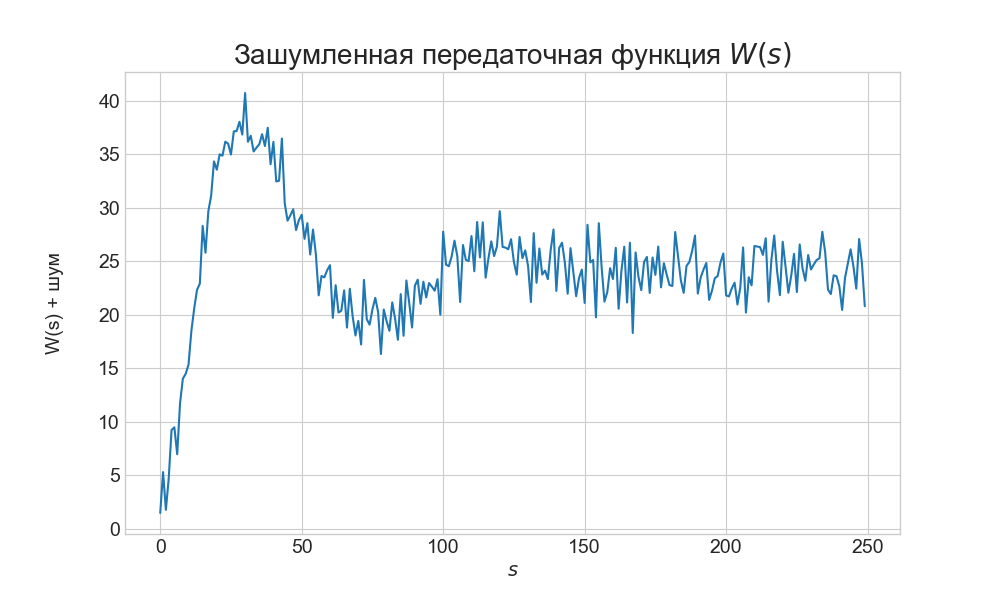

In [10]:
# Визуализация 
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(noise_result)

ax.set_xlabel('$s$', fontsize=14)
ax.set_ylabel('W(s) + шум', fontsize=14, rotation=90, labelpad=25)
ax.set_title('Зашумленная передаточная функция $W(s)$', fontsize=20)

plt.show()


## Этап 4. Формирование целевой функции

По условию задана данная целевая функция:

$ CF = \frac{1}{n + 1} * \sum^{n}_{i=0}{(y^{э}_{i} - y^{м}_{i})^2} \rightarrow min$

где: 
* $y^{э}$ - зашумленная функция
* $y^{м}$ = функция, найденная через метод поисковой оптимизации
* n - размер выборки

**Для данной передаточной функции** $W(s) = \frac{k(1+a_1*s)}{1+2 * \mu*T*s+T^2*s^2} = \frac{\bar{y}(s)}{\bar{x}(s)} = \frac{P(s)}{Q(s)}$

где: 
* $x(t) = const = 12$
* $k = 2$
* $a_1 = 2$
* $\mu = 0.3$ **Данный параметр будет принят за неизвестную переменную**
* $T = 2$ **Данный параметр будет принят за неизвестную переменную**

In [11]:
def CF(mu:float, T:float) -> float:
    """
    Целевая функция
    
    x1: float - 1ая неизвестная переменная
    x2: float - 2ая неизвестная переменная
    
    return: float
    """
    global noise_result
    n = len(noise_result)
    
    # получение массива данных из передаточной функции. (250 точек)
    h: float = 0.15
    f: Generator[float, float, None] = transfer_func(12, 2, 2, mu, T, h)
    test_result = [next(f) for _ in range(250)]
    
    return (1 / (n + 1)) * sum([
        (y_ex - y_mod) ** 2
        for y_ex, y_mod 
        in zip(noise_result, test_result)
    ])

## Этап 5. Реализиация метода оптимизации. Применение метода на целевой функции

In [12]:
def one_param_min(f, param, fix_step, eps, iter_=1000):
    """
    f - функция от одной перменной
    param - параметр для минимизациии
    fix_step - шаг
    eps - погрешность
    iter - максимальное количество итераций
    """
    import math
    prev_res = f(param)
    curr_res = -math.inf
    param1, param2 = param + fix_step, param - fix_step
    res1, res2 = f(param1), f(param2)
    if res1 <= res2:
        param = param1
        curr_res = res1
    else:
        param = param2
        curr_rest = res2
    
    # максимум iter_ итераций
    for i in range(iter_):
        if abs(abs(curr_res) - abs(prev_res)) <= eps:
            return param
        param1, param2 = param + fix_step, param - fix_step
        res1, res2 = f(param1), f(param2)
        if res1 <= res2:
            param = param1
            prev_res, curr_res = curr_res, res1
        else:
            param = param2
            prev_res, curr_rest = curr_res, res2
    
    return param
        
    
def coord_descent(f, x: float, y: float, fix_step: float, eps: float, iter_=1000):
    """
    f - функция 
    x, y - начальные точки
    fix_step - шаг спуска
    eps - граница погрешности
    iter - максимальное количество итераций
    
    :return: (x, y, z, iter_, dots) - точка минимума
    """
    dots = [] # для traceback
    dots.append([x, y, f(x, y)])
    
    prev_res = f(x, y)
    x = one_param_min((lambda x: f(x, y)), x, fix_step, eps, iter_)
    dots.append([x, y, f(x, y)])
    
    y = one_param_min((lambda y: f(x, y)), y, fix_step, eps, iter_)
    curr_res = f(x, y)
    dots.append([x, y, curr_res])

    # максимум iter_ итераций
    for i in range(iter_):
        if abs(abs(curr_res) - abs(prev_res)) <= eps:
            dots.append([x, y, curr_res])
            return (x, y, curr_res, i, dots)
        
        x = one_param_min((lambda x: f(x, y)), x, fix_step, eps, iter_)
        dots.append([x, y, f(x, y)])
        
        y = one_param_min((lambda y: f(x, y)), y, fix_step, eps, iter_)
        prev_res, curr_res = curr_res, f(x, y)
        dots.append([x, y, curr_res])
    dots.append([x, y, curr_res])
    return (x, y, curr_res, iter_, dots)

#### Проверка на целевой функции

Для более наглядного результата выберем 5 различных начальных значений для неизвестных переменных:

1) $\Delta$0.1, $\Delta$0.1

2) $\Delta$0.3, $\Delta$0.7

3) $\Delta$0.7, $\Delta$3.1

4) $\Delta$2.5, $\Delta$4.4

5) $\Delta$5.1, $\Delta$7.2

6) $\Delta$10, $\Delta$20



In [13]:
eps = 10**(-6) # погрешность
fix_step = 0.005 # шаг
iter_ = 10000 # максимальное количество итераций для вычисления

deltas = [
    [0.1, 0.1],
    [0.3, 0.7],
    [0.7, 3.1],
    [2.5, 4.4],
    [5.1, 7.2],
    [10, 20]
]

results = []

for d_mu, d_T in deltas:
    mu_test = 0.3 - d_mu
    T_test = 2 - d_T
    fst, scnd, result, iterations, table  = coord_descent(CF, mu_test, T_test, fix_step, eps, iter_)
    results.append(
        [mu_test, T_test, fst, scnd, result, iterations, table]
    )

## Почему отрицательные результаты? Проблема кроется в самой передаточной функции:

$ W(s) = \frac{k(1+a_1*s)}{1+2 * \mu*T*s+T^2*s^2} $

1) Из данной функции видно, что **участок $\mu*T*s$ при отрицательных $\mu$ и T всегда будет положительным**, а значит поисковая оптимизация не будет видеть ошибки в данных значениях и достигнув минимума по одному из параметров перейдет к другому.

2) Участок $T^2$ **при любом отрицательном T** будет давать **положительный результат**

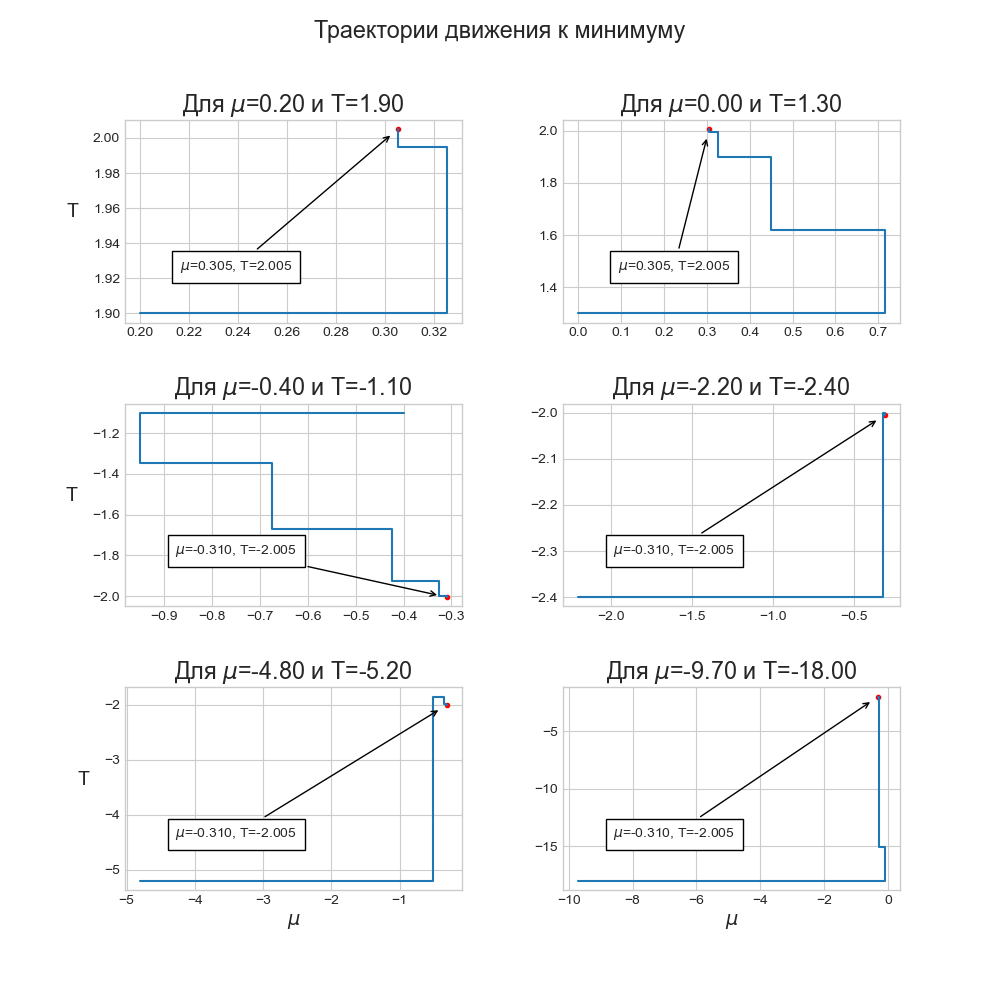

In [14]:
# Визуализация
plt.style.use('seaborn-whitegrid')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle("Траектории движения к минимуму")


for ax, res in zip(axs.flat, results):
    ax.tick_params(labelsize=10)
    # точки
    x = [float(str_[0]) for str_ in res[-1]]
    y = [float(str_[1]) for str_ in res[-1]]

    ax.set_title(f"Для $\mu$={res[0]:3.2f} и T={res[1]:3.2f}")
    
    if not ax.is_last_col():
        ax.set_ylabel("T", rotation=0, labelpad=15)
    if ax.is_last_row():
        ax.set_xlabel("$\mu$")
    
    ax.plot(x[-1], y[-1], ".r")
    offsetbox = TextArea(f"$\mu$={res[2]:3.3f}, T={res[3]:3.3f}", textprops=dict(size=10))
    new_res = AnnotationBbox(
        offsetbox, (x[-1], y[-1]),
        xybox=(80, 40),
        xycoords='data',
        boxcoords=('axes points'),
        box_alignment=(0.5, 0.5),
        arrowprops=dict(arrowstyle='->, head_length=0.2, head_width=0.1', shrinkB=7)
    )
    ax.add_artist(new_res)
    
    ax.plot(x, y)

plt.show()

## Этап 6. Построение графика сигналов

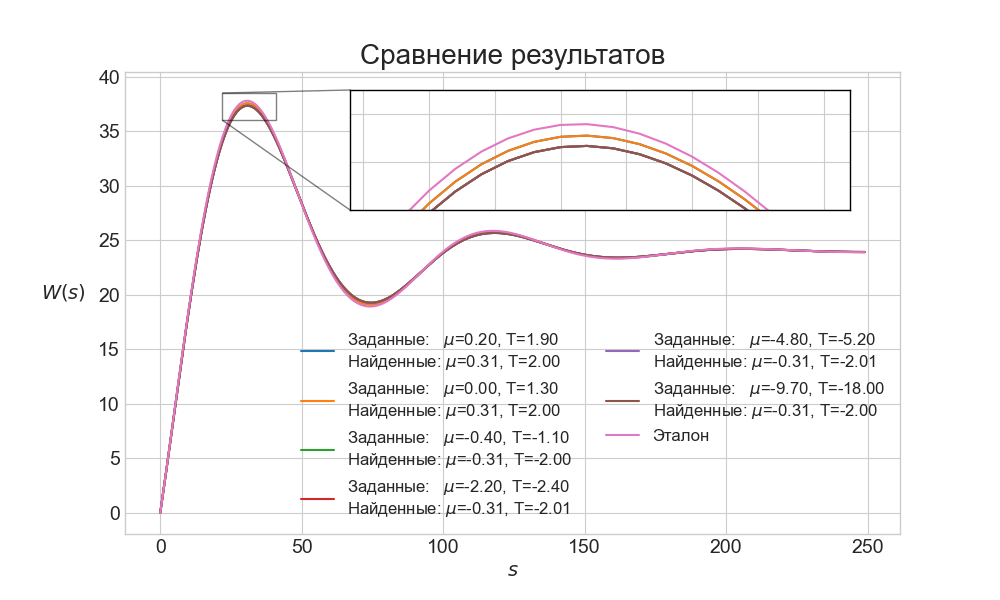

In [15]:
# Визуализация 
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('$s$', fontsize=14)
ax.set_ylabel('$W(s)$', fontsize=14, rotation=0, labelpad=25)
ax.set_title('Сравнение результатов', fontsize=20)

for res in results:
    mu, T = res[2:4]
    h: float = 0.15
    f: Generator[float, float, None] = transfer_func(12, 2, 2, mu, T, h)
    test_result = [next(f) for _ in range(250)]
    ax.plot(test_result, visible=True, label=f"Заданные:   $\mu$={res[0]:3.2f}, T={res[1]:3.2f}\nНайденные: $\mu$={mu:3.2f}, T={T:3.2f}")
ax.plot(clean_result, label="Эталон")
plt.legend(ncol=2, prop=dict(size=12))

# inset axes....
# ax2 = fig.add_axes([l, b, w, h])
# ax2.plot([1, 4, 6, 2, 1, 5, 2], color='green', lw=3, label="inside plot")

axins = fig.add_axes([0.35, 0.65, 0.5, 0.2])
# sub region of the original image
x1, x2, y1, y2 = 22, 41, 36, 38.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.spines['bottom'].set_color('black')
axins.spines['top'].set_color('black') 
axins.spines['right'].set_color('black')
axins.spines['left'].set_color('black')

for res in results:
    mu, T = res[2:4]
    h: float = 0.15
    f: Generator[float, float, None] = transfer_func(12, 2, 2, mu, T, h)
    test_result = [next(f) for _ in range(250)]
    axins.plot(test_result, visible=True)
axins.plot(clean_result)
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()